# Synthesize fake images by CAMs-based GAN

Written by Weisen Wang

2022-06-06

## Environment
+ Ubuntu 18.04.5 LTS
+ Python 3.7.12
+ conda install pytorch==1.1.0 torchvision==0.3.0 cudatoolkit=10.0 
+ See requirements.txt for other python packages

In [1]:
import os
os.chdir("../code/")

import torch
import models
import utils
import data
import random
import numpy as np
import cv2 as cv
from PIL import Image

from data import augmentation
from drawers import CAMDrawer

import sys
sys.path.append(os.path.join(os.getcwd(), 'camconditioned_pix2pixHD'))
from camconditioned_pix2pixHD.util.util import load_cam, tensor2im
from camconditioned_pix2pixHD.models.models import create_model
from camconditioned_pix2pixHD.options.test_options import TestOptions

def set_opt(checkpoint_netG):
    opt = TestOptions().parse(save=False)
    opt.nThreads = 1   # test code only supports nThreads = 1
    opt.batchSize = 1  # test code only supports batchSize = 1
    opt.serial_batches = True  # no shuffle
    opt.no_flip = True  # no random flip
    opt.gan_aug = False

    opt.camlabel = True
    opt.checkpoint_netG = checkpoint_netG
    opt.netG = "local" 
    opt.ngf = 32 
    opt.resize_or_crop = "resize_and_crop" 
    opt.loadSize = 512 
    opt.fineSize = 512 
    opt.no_instance =True
    
    return opt

# 1. Synthesize fake CFP

## Step 1. Load a trained CFP single-modal  model

In [2]:
device = 3
device = torch.device("cuda: {}".format(device) if (torch.cuda.is_available() and device != "cpu") else "cpu")
configs = utils.load_config("config-cfp.py")
configs.heatmap = True

label_list = 'h d p w'.split() # normal, dryAMD, pcv and wetAMD
n_classes = len(label_list)
checkpoint = "weights/weights_splitAP/cfp-clahe.pth"

model = models.load_single_stream_model(configs, device, checkpoint)
model.eval()
print ()

load checkpoint 'weights/weights_splitAP/cfp-clahe.pth'



## Step 2. Generate CFP CAMs

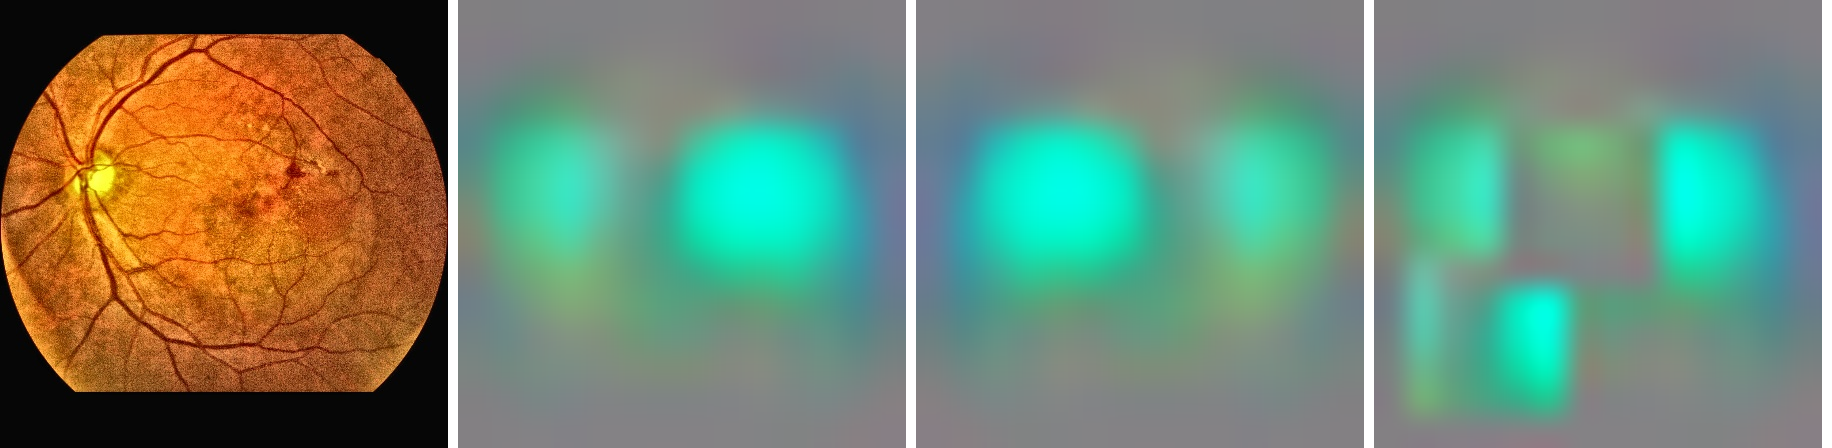

In [3]:
impath = "test_images/test-f-p.jpg"
label = 'd'
raw_im, new_im = data.load_image(impath, configs)
new_im = np.squeeze(new_im)

cam_drawer = CAMDrawer(model, device)
# original CAMs
cams = cam_drawer.get_cam(torch.unsqueeze(new_im, dim=0), save_path="test_images/test-f-p.jpg.npy")
# manipulated CAMs
cams_flip = cam_drawer.flip(cams, save_path="test_images/test-f-p-flip.jpg.npy")
cams_move = cam_drawer.move(cams, reference_channel=label_list.index(label)-1, save_path="test_images/test-f-p-move.jpg.npy")
CAMDrawer.sequence_visualize(raw_im, [cams, cams_flip, cams_move], visual_size=(448,448))

## Step 3. Load a trained CFP pix2pixHD

In [4]:
generater_checkpoint = "weights/weights_splitAP/cfp_net_G.pth"
opt = set_opt(generater_checkpoint)
model = create_model(opt)

## Step 4. Generate fake CFP

/data4/wws/jbhi0605/mmc-amd-main/code/camconditioned_pix2pixHD/models/pix2pixHD_model.py:130: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_label = Variable(input_label, volatile=infer)


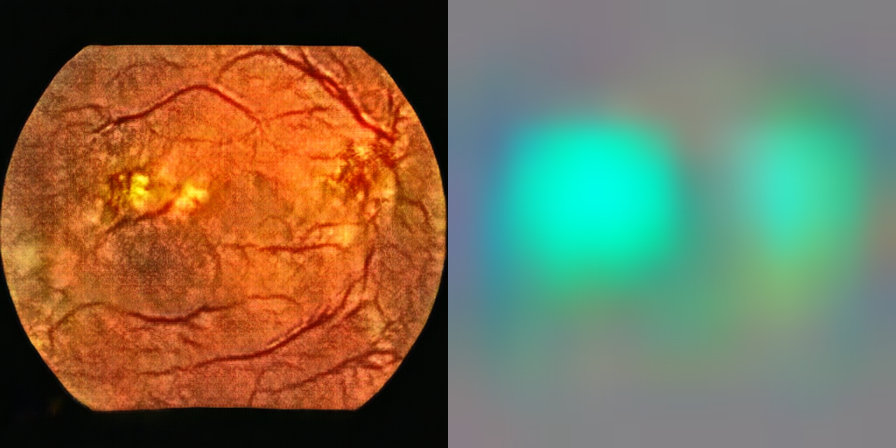

In [5]:
cams_path = "test_images/test-f-p-flip.jpg.npy"
inputs, cams = load_cam(path=cams_path, opt=opt)
generated = model.inference(inputs.to(device), torch.tensor([0]).to(device), torch.tensor([0]).to(device))
image_numpy = tensor2im(generated.data[0])
CAMDrawer.visualize(cv.cvtColor(tensor2im(generated.data[0]),cv.COLOR_RGB2BGR), cams, visual_size=(448,448))

# 2. Synthesize fake OCT

## Step 1. Load a trained OCT single-modal  model

In [6]:
device = 2
device = torch.device("cuda: {}".format(device) if (torch.cuda.is_available() and device != "cpu") else "cpu")
configs = utils.load_config("config-oct.py")
configs.heatmap = True

label_list = 'h d p w'.split() # normal, dryAMD, pcv and wetAMD
n_classes = len(label_list)
checkpoint = "weights/weights_splitAP/oct-median3x3.pth"

model = models.load_single_stream_model(configs, device, checkpoint)
model.eval()
print ()

load checkpoint 'weights/weights_splitAP/oct-median3x3.pth'



## Step 2. Generate OCT CAMs

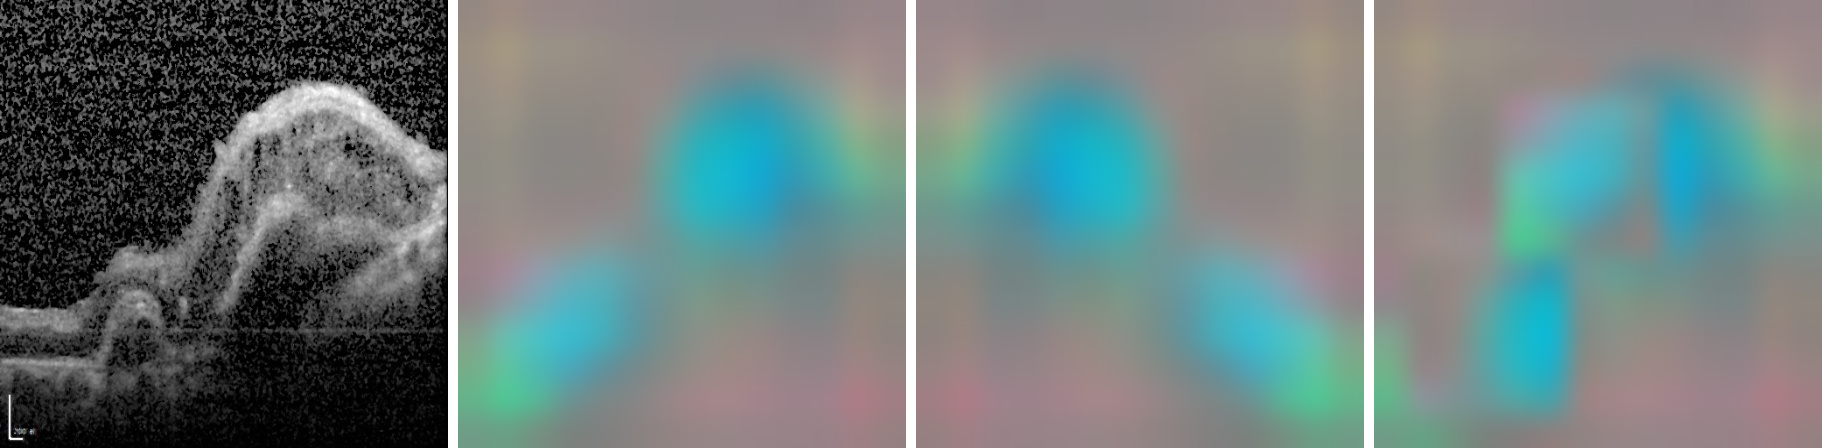

In [7]:
impath = "test_images/test-o-p.jpg"
label = 'p'
raw_im, new_im = data.load_image(impath, configs)
new_im = np.squeeze(new_im)

cam_drawer = CAMDrawer(model, device)
# original CAMs
cams = cam_drawer.get_cam(torch.unsqueeze(new_im, dim=0), save_path="test_images/test-f-o.jpg.npy")
# manipulated CAMs
cams_flip = cam_drawer.flip(cams, save_path="test_images/test-f-o-flip.jpg.npy")
cams_move = cam_drawer.move(cams, reference_channel=label_list.index(label)-1, save_path="test_images/test-f-o-move.jpg.npy")
CAMDrawer.sequence_visualize(raw_im, [cams, cams_flip, cams_move], visual_size=(448,448))

## Step 3. Load a trained CFP pix2pixHD

In [8]:
generater_checkpoint = "weights/weights_splitAP/oct_net_G.pth"
opt = set_opt(generater_checkpoint)
model = create_model(opt)

## Step 4. Generate fake CFP

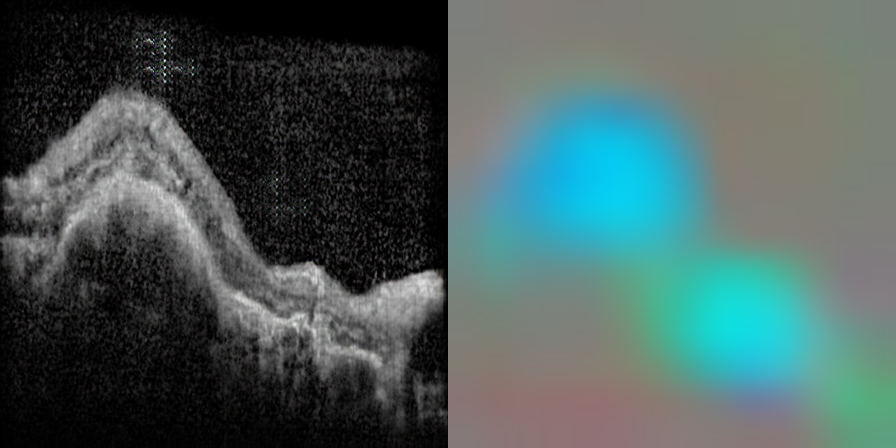

In [9]:
cams_path = "test_images/test-o-p-flip.jpg.npy"
inputs, cams = load_cam(path=cams_path, opt=opt)
generated = model.inference(inputs.to(device), torch.tensor([0]).to(device), torch.tensor([0]).to(device))
image_numpy = tensor2im(generated.data[0])
CAMDrawer.visualize(cv.cvtColor(tensor2im(generated.data[0]),cv.COLOR_RGB2BGR), cams, visual_size=(448,448))